# **Rice Plant Disease Classification using CNN Transfer Learning**
___

## Dataset Preparation

### Split Datasets

In [ ]:
dataset = r"D:\Final\Datasets"
dataset_dir = r"D:\Final\Splitted Datasets"

I have 11 classes with 1000 images per class. I used 80 % for training, 10% for validation, and the remaining 10% for testing.

In [ ]:
#pip install split-folders
import splitfolders

# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio(
        dataset, 
        output=dataset_dir,
        seed=1337, 
        ratio=(.8, .1, .1), 
        group_prefix=None, 
        move=False
    ) # default values

### Path to my new datasets

In [1]:
trainpath= 'D:/Final/Splitted Datasets/train'
validpath='D:/Final/Splitted Datasets/val'
testpath='D:/Final/Splitted Datasets/test'

Image Size

In [2]:
img_width, img_height = (224,224)

## Data Preprocessing and Augumentation    
Examples:   
- To balance the dataset and to increase the size of training and testing dataset
- Regularization technique to minimize overfitting
- Rescaling the image is Normalizing the image

In this notebook, I will not used any techniques for augmenting images since my datasets already augmented to avoid overfitting. The datasets was collected from different repositories, and already increase its size using data augmentation that's why it is up to 1000 images per class.

In [4]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input


Batch Size

In [3]:
batch_size = 20

In [5]:
train_data_generator = ImageDataGenerator(
        preprocessing_function=preprocess_input 
    )

train_set = train_data_generator.flow_from_directory(
        trainpath,
        target_size=(img_width,img_height),
        batch_size=batch_size,
        class_mode='categorical'
    )

valid_data_generator = ImageDataGenerator(
        preprocessing_function=preprocess_input
    )

valid_set = valid_data_generator.flow_from_directory(
        validpath,
        target_size=(img_width,img_height),
        batch_size=batch_size,
        class_mode='categorical', 
        shuffle=False 
    )

test_data_generator= ImageDataGenerator()

test_set = test_data_generator.flow_from_directory(
        testpath,
        target_size=(img_width,img_height),
        batch_size=batch_size, 
        class_mode='categorical', 
        shuffle=False
    )

Found 8734 images belonging to 11 classes.
Found 1092 images belonging to 11 classes.
Found 1091 images belonging to 11 classes.


Number of Batches per epoch

In [6]:
# To print number of batches per epoch
print('Number of Batches per epoch train=%d, valid=%d ,test=%d' % (len(train_set), len(valid_set),len(test_set)))

Number of Batches per epoch train=437, valid=55 ,test=55


## CNN Model

I have already trained other type of CNN models, and this model will got the highest accuracy.
See other models for comparison at : https://github.com/wilfredpine/Rice-Disease-Classification-using-CNN-Models/

**[Using ResNet50 Model](https://keras.io/api/applications/#available-models)**

In [7]:
from tensorflow.keras.applications.resnet50 import ResNet50

In [8]:
base_model = ResNet50(
        input_shape = (img_width, img_height, 3), 
        include_top = False, 
        weights = 'imagenet'
    )

In [9]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

## Transfer Learning

In [10]:
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import keras

In [11]:
x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Flatten()(base_model.output)
x = keras.layers.Dense(1024, activation='relu')(x)

x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(512, activation='relu')(x)

x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(train_set.num_classes, activation='softmax')(x)

for layer in base_model.layers[:-100]:
   layer.trainable = False

model = tf.keras.models.Model(base_model.input, x)

model.compile(
        optimizer = Adam(learning_rate=0.000001), 
        loss = 'categorical_crossentropy', 
        metrics = ['acc']
    )

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

## Train the Model

In [13]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

where you save your model

In [14]:
saved_model = "D:/Final/Model/Rice_ResNet50_50epochs.h5"

Using [Callbacks](https://keras.io/api/callbacks/)

Checkpoint strategy is to save the model weights to the same file if and only if the validation accuracy improves.

In [15]:
# Saving the model according to the conditions  
checkpoint = ModelCheckpoint(
        saved_model, 
        monitor='val_loss', 
        verbose=1, 
        save_best_only=True, 
        mode='auto'
    )


Reduce learning rate when a metric has stopped improving.

In [ ]:
# 
reduce = ReduceLROnPlateau(
        monitor='val_loss', 
        verbose=1, 
        factor=0.1, 
        patience=2, 
        mode='auto'
    )

Number of Epochs

In [16]:
epochs = 50

Start Training

In [17]:
# Train the model
trained_model = model.fit(
        train_set,
        steps_per_epoch = train_set.samples//train_set.batch_size,
        epochs = epochs,
        validation_data = valid_set,
        validation_steps = valid_set.samples//valid_set.batch_size,
        callbacks=[checkpoint,reduce]
    )


Epoch 1/50
 31/436 [=>............................] - ETA: 18:17 - loss: 5.8176 - acc: 0.1032

c:\Users\IT Room202\AppData\Local\Programs\Python\Python310\lib\site-packages\PIL\Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


436/436 [==============================] - ETA: 0s - loss: 3.9522 - acc: 0.1749
Epoch 1: val_loss improved from inf to 1.26786, saving model to D:/Final/Model\Rice_ResNet50_50epochs.h5
436/436 [==============================] - 1293s 3s/step - loss: 3.9522 - acc: 0.1749 - val_loss: 1.2679 - val_acc: 0.6083 - lr: 1.0000e-06
Epoch 2/50
436/436 [==============================] - ETA: 0s - loss: 2.3468 - acc: 0.3603
Epoch 2: val_loss improved from 1.26786 to 0.82013, saving model to D:/Final/Model\Rice_ResNet50_50epochs.h5
436/436 [==============================] - 1250s 3s/step - loss: 2.3468 - acc: 0.3603 - val_loss: 0.8201 - val_acc: 0.7611 - lr: 1.0000e-06
Epoch 3/50
436/436 [==============================] - ETA: 0s - loss: 1.6734 - acc: 0.4958
Epoch 3: val_loss improved from 0.82013 to 0.61473, saving model to D:/Final/Model\Rice_ResNet50_50epochs.h5
436/436 [==============================] - 1269s 3s/step - loss: 1.6734 - acc: 0.4958 - val_loss: 0.6147 - val_acc: 0.8204 - lr: 1.0000

Save the Model in JSON (if you use javascript libraries for your application)

In [18]:
# model.save("resnet5050")
# model.save("resnet5050.h5")

s = model.to_json()
with open('resnet50_model.json', 'w') as f:
    f.write(s)

# model.save_weights("resnet5050weights.h5")
# model.save_weights("resnet5050weights")

INFO:tensorflow:Assets written to: resnet5050\assets


INFO:tensorflow:Assets written to: resnet5050\assets


## Model History

Accuracy and Loss

In [20]:
training_accuracy      = trained_model.history['acc'][-1]
training_loss          = trained_model.history['loss'][-1]
validation_accuracy    = trained_model.history['val_acc'][-1]
validation_loss       = trained_model.history['val_loss'][-1]
print("Training Accuracy   :", training_accuracy )
print("Training Loss       :", training_loss)
print("Validation Accuracy :", validation_accuracy)
print("Validation Loss     :", validation_loss)

Training Accuracy   : 0.970048189163208
Training Loss       : 0.0901964083313942
Validation Accuracy : 0.9620370268821716
Validation Loss     : 0.11565300822257996


Loss and Accuracy Visualization

In [19]:
import matplotlib.pyplot as plt

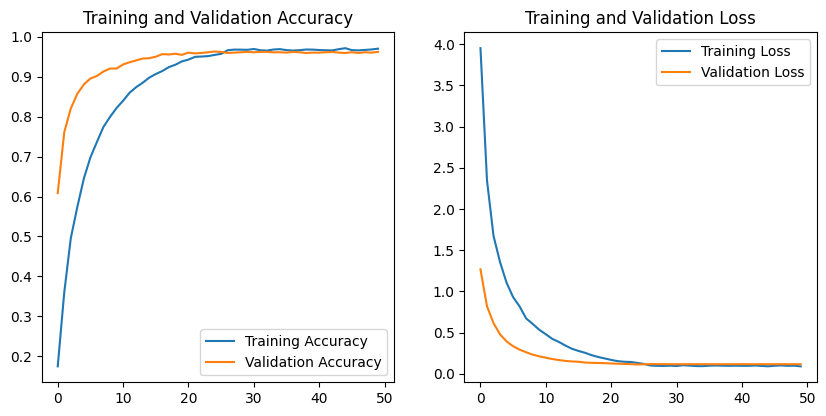

In [22]:
acc = trained_model.history['acc']
val_acc = trained_model.history['val_acc']
loss = trained_model.history['loss']
val_loss = trained_model.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Load Model

In [23]:
import tensorflow as tf
new_model = tf.keras.models.load_model(saved_model)


## Prediction

In [24]:
predict = new_model.predict(
        test_set,
        steps=len(test_set),
        verbose=1
    )

55/55 [==============================] - 74s 1s/step


In [25]:
predict

array([[1.6231628e-01, 7.5522619e-01, 2.2378629e-02, ..., 1.7609794e-04,
        1.1380276e-03, 2.4986753e-04],
       [2.2303893e-01, 2.9165003e-02, 3.4620850e-03, ..., 5.8281366e-03,
        2.4676258e-03, 5.1992228e-03],
       [1.9266635e-01, 4.9565746e-03, 2.0082009e-03, ..., 8.5128080e-03,
        2.2249552e-03, 9.1657033e-03],
       ...,
       [3.9156485e-02, 5.6013651e-02, 4.2203506e-03, ..., 2.1020871e-02,
        1.4895179e-03, 6.9631147e-01],
       [4.9951015e-04, 1.9445733e-04, 1.2019902e-04, ..., 6.5898657e-04,
        1.3376882e-04, 5.1343311e-02],
       [1.5537209e-03, 7.6516101e-04, 1.5549526e-04, ..., 3.7791640e-03,
        4.2163220e-04, 3.2241076e-01]], dtype=float32)

In [28]:
import numpy as np
rounded_predictions = np.argmax(predict,axis=-1)
rounded_predictions

array([ 1,  3,  5, ..., 10,  5,  5], dtype=int64)

In [29]:
rounded_predictions.shape

(1091,)

In [30]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

In [31]:
test_set.class_indices

{'Bacterial_Blight': 0,
 'Blast': 1,
 'Brown_Spot': 2,
 'False_Smut': 3,
 'Healthy': 4,
 'Healthy_Flowers': 5,
 'Hispa': 6,
 'Leaf_Smut': 7,
 'Sheath_Blight': 8,
 'Tungro': 9,
 'Unhealthy_Flowers': 10}

In [32]:
test_labels=test_set.classes
test_labels

array([ 0,  0,  0, ..., 10, 10, 10])

In [33]:
test_labels.shape

(1091,)

#### Confusion Matrix

In [35]:
cm = confusion_matrix(y_true=test_labels, y_pred=rounded_predictions)
cm

array([[70, 13,  0,  2,  2,  5,  7,  0,  0,  1,  0],
       [ 3, 66,  5,  0,  2,  0, 23,  0,  1,  0,  0],
       [ 0,  3, 75,  0,  3,  0, 18,  1,  0,  0,  0],
       [ 0,  0,  0, 88,  5,  2,  3,  0,  1,  0,  1],
       [ 0,  0,  0,  0, 94,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  4,  5, 88,  0,  0,  0,  0,  3],
       [ 0,  3,  3,  1,  0,  0, 90,  0,  0,  0,  0],
       [ 0,  0,  3,  0,  0,  0,  1, 96,  0,  0,  0],
       [ 0,  7,  2,  7,  6,  1,  3,  3, 70,  0,  1],
       [ 0,  0,  0,  1, 16,  0,  2,  0,  0, 79,  2],
       [ 0,  0,  0,  3,  9, 34,  1,  0,  0,  0, 53]], dtype=int64)

In [34]:
class_list = []
for keys in test_set.class_indices.keys():
    class_list.append(keys)

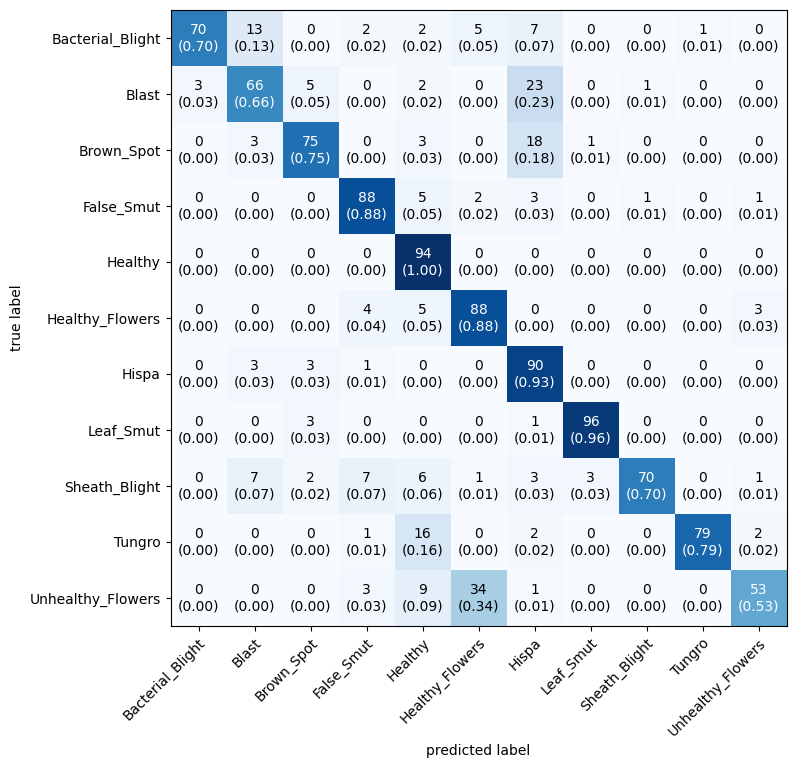

In [36]:
fig,ax=plot_confusion_matrix(conf_mat=cm,figsize=(8,8),show_normed=True, class_names=class_list)
plt.show()


##### **Test Accuracy**

In [37]:
print('test accuracy: {0:2f}'.format((np.diagonal(cm).sum()/cm.sum().sum()*100)))

test accuracy: 79.651696


---

##### Other Plotting Library

Using Seaborn

<AxesSubplot: >

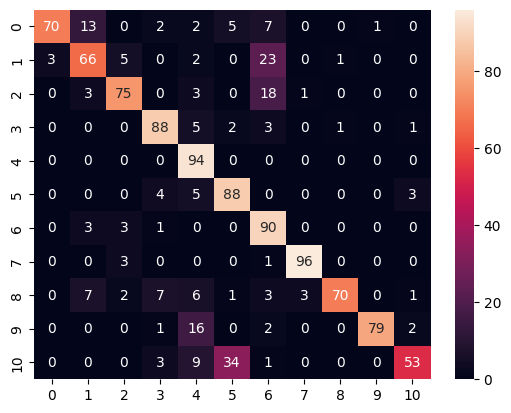

In [38]:
import seaborn as sns
sns.heatmap(cm, annot=True)

<AxesSubplot: >

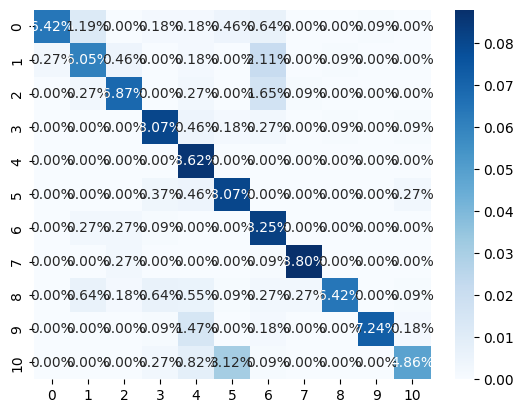

In [39]:
sns.heatmap(
        cm/np.sum(cm), 
        annot=True, 
        fmt='.2%', 
        cmap='Blues'
    )

---

### Classification Report

In [40]:
import sklearn.metrics as metrics

In [41]:
class_list = []
for keys in test_set.class_indices.keys():
    class_list.append(keys)

class_list

['Bacterial_Blight',
 'Blast',
 'Brown_Spot',
 'False_Smut',
 'Healthy',
 'Healthy_Flowers',
 'Hispa',
 'Leaf_Smut',
 'Sheath_Blight',
 'Tungro',
 'Unhealthy_Flowers']

In [42]:

classify_report = metrics.classification_report(
        y_true=test_labels, 
        y_pred=rounded_predictions,
        target_names=class_list
    )

print('classify_report : \n', classify_report)


classify_report : 
                    precision    recall  f1-score   support

 Bacterial_Blight       0.96      0.70      0.81       100
            Blast       0.72      0.66      0.69       100
       Brown_Spot       0.85      0.75      0.80       100
       False_Smut       0.83      0.88      0.85       100
          Healthy       0.66      1.00      0.80        94
  Healthy_Flowers       0.68      0.88      0.77       100
            Hispa       0.61      0.93      0.73        97
        Leaf_Smut       0.96      0.96      0.96       100
    Sheath_Blight       0.97      0.70      0.81       100
           Tungro       0.99      0.79      0.88       100
Unhealthy_Flowers       0.88      0.53      0.66       100

         accuracy                           0.80      1091
        macro avg       0.83      0.80      0.80      1091
     weighted avg       0.83      0.80      0.80      1091



In [43]:
overall_accuracy = metrics.accuracy_score(
        y_true=test_labels, 
        y_pred=rounded_predictions
    )
acc_for_each_class = metrics.precision_score(
        y_true=test_labels, 
        y_pred=rounded_predictions, 
        average=None
    )
average_accuracy = np.mean(acc_for_each_class)
score = metrics.accuracy_score(
        y_true=test_labels, 
        y_pred=rounded_predictions
    )

print('ac_for_each_class : \n', acc_for_each_class)
print('average_accuracy: {0:2f}'.format(average_accuracy))
print('overall_accuracy: {0:2f}'.format(overall_accuracy))
print('score: {0:f}'.format(score))

ac_for_each_class : 
 [0.95890411 0.7173913  0.85227273 0.83018868 0.66197183 0.67692308
 0.60810811 0.96       0.97222222 0.9875     0.88333333]
average_accuracy: 0.828074
overall_accuracy: 0.796517
score: 0.796517


### ROC Curve

In [44]:
from sklearn.metrics import roc_curve

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(test_labels, predict[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(test_labels))]
p_fpr, p_tpr, _ = roc_curve(test_labels, random_probs, pos_label=1)

C:\Users\IT Room202\AppData\Local\Temp\ipykernel_3920\1087658176.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


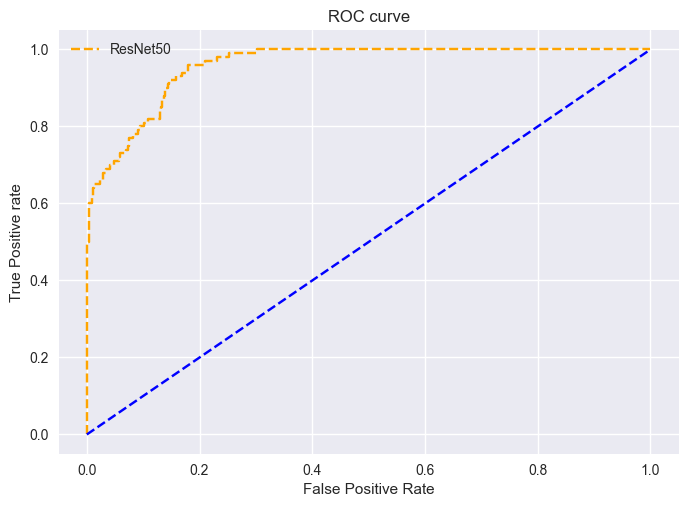

In [46]:
# matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='ResNet50')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

### ROC Area Under Curve (AUC) Score

In [47]:
from sklearn.metrics import roc_auc_score

# auc scores
# auc_score1 = roc_auc_score(test_labels, predict[:,1])
auc_score1 = roc_auc_score(y_score=predict, y_true=test_labels, multi_class="ovr",average=None)

ind = 0
for score in auc_score1:
    print("%s : %.3f" % (class_list[ind], score))
    ind += 1

Bacterial_Blight : 0.988
Blast : 0.958
Brown_Spot : 0.970
False_Smut : 0.994
Healthy : 0.999
Healthy_Flowers : 0.978
Hispa : 0.981
Leaf_Smut : 0.999
Sheath_Blight : 0.994
Tungro : 0.993
Unhealthy_Flowers : 0.963


---

## Model Implementation

---

### Test Single Image

Using opencv-python library to read and process the image before prediction

(1, 224, 224, 3)


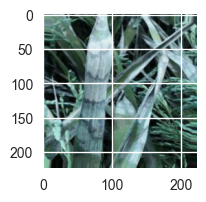

In [77]:
import cv2
import numpy as np
image=cv2.imread("D:/Testing/sheathblight (2).jpg")
#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img_resized=cv2.resize(image, (img_width, img_height))
image=np.expand_dims(img_resized,axis=0)
print(image.shape)

plt.figure(figsize = (2,2))
plt.imshow(img_resized)
plt.show()

Prediction

In [78]:
prediction = new_model.predict(image)
print(prediction)

1/1 [==============================] - 0s 133ms/step
[[1.1786100e-03 9.6027194e-05 1.7638872e-06 1.5437280e-04 1.7707438e-04
  5.1659788e-04 9.9528574e-05 4.3916662e-06 9.9748367e-01 7.8225130e-06
  2.8019253e-04]]


Predicted Class

In [79]:
class_output = class_list[np.argmax(prediction)]
print(class_output)

Sheath_Blight


Accuracy

In [80]:
predicted_acuracy = ("{:.2%}".format(np.array(prediction[0])[np.argmax(prediction)]))
print(predicted_acuracy)

99.75%


Scores of Prediction per Classes

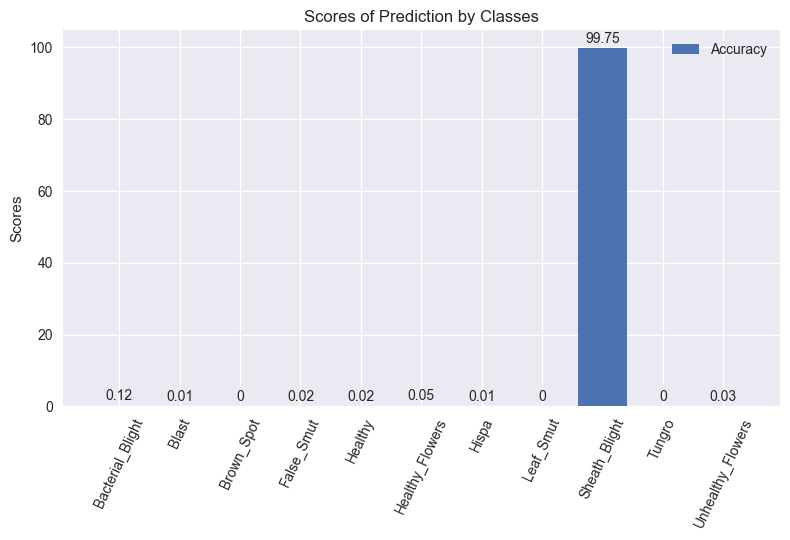

In [81]:
import matplotlib.pyplot as plt
import numpy as np

labels = class_list
values = list(np.array(np.around(prediction[0] * 100,2)))

x = np.arange(len(labels))  # the label locations
width = 0.80  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x, values, width, label='Accuracy')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores of Prediction by Classes')
ax.set_xticks(x, labels)
plt.xticks(rotation=65)
ax.legend()

ax.bar_label(rects1, padding=2)

fig.tight_layout()

plt.show()

---

### Test-on-Test Data

1/1 [==============================] - 0s 140ms/step


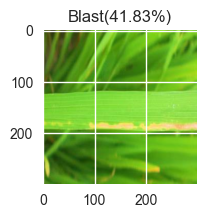

----------------------------------------------------------------------------------
1/1 [==============================] - 0s 142ms/step


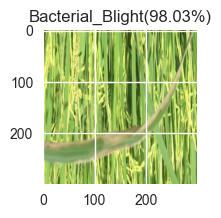

----------------------------------------------------------------------------------
1/1 [==============================] - 0s 155ms/step


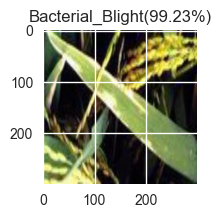

----------------------------------------------------------------------------------
1/1 [==============================] - 0s 128ms/step


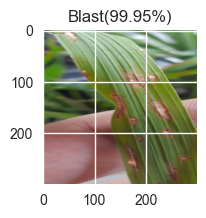

----------------------------------------------------------------------------------
1/1 [==============================] - 0s 130ms/step


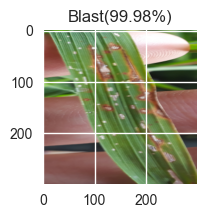

----------------------------------------------------------------------------------
1/1 [==============================] - 0s 130ms/step


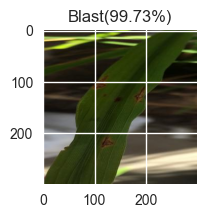

----------------------------------------------------------------------------------
1/1 [==============================] - 0s 147ms/step


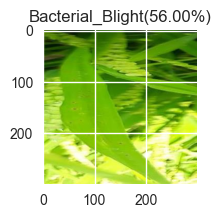

----------------------------------------------------------------------------------
1/1 [==============================] - 0s 124ms/step


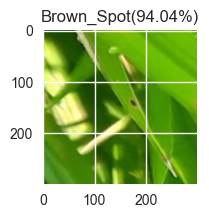

----------------------------------------------------------------------------------
1/1 [==============================] - 0s 120ms/step


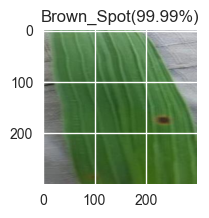

----------------------------------------------------------------------------------
1/1 [==============================] - 0s 127ms/step


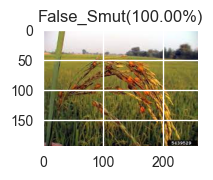

----------------------------------------------------------------------------------
1/1 [==============================] - 0s 123ms/step


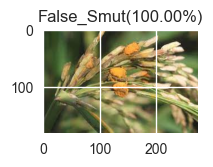

----------------------------------------------------------------------------------
1/1 [==============================] - 0s 121ms/step


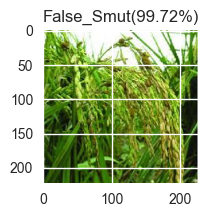

----------------------------------------------------------------------------------
1/1 [==============================] - 0s 117ms/step


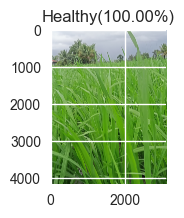

----------------------------------------------------------------------------------
1/1 [==============================] - 0s 122ms/step


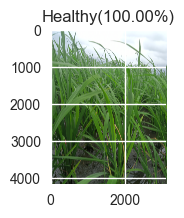

----------------------------------------------------------------------------------
1/1 [==============================] - 0s 126ms/step


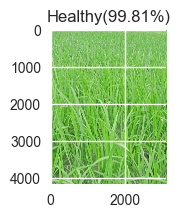

----------------------------------------------------------------------------------
1/1 [==============================] - 0s 126ms/step


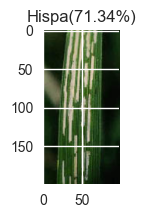

----------------------------------------------------------------------------------
1/1 [==============================] - 0s 125ms/step


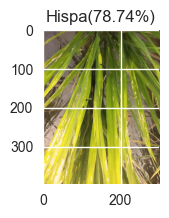

----------------------------------------------------------------------------------
1/1 [==============================] - 0s 123ms/step


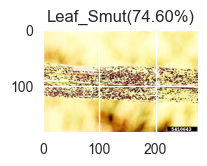

----------------------------------------------------------------------------------
1/1 [==============================] - 0s 124ms/step


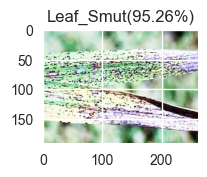

----------------------------------------------------------------------------------
1/1 [==============================] - 0s 123ms/step


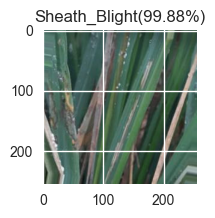

----------------------------------------------------------------------------------
1/1 [==============================] - 0s 133ms/step


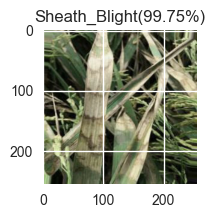

----------------------------------------------------------------------------------
1/1 [==============================] - 0s 125ms/step


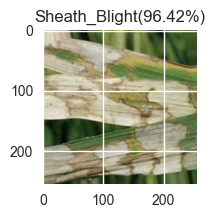

----------------------------------------------------------------------------------
1/1 [==============================] - 0s 130ms/step


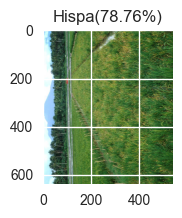

----------------------------------------------------------------------------------
1/1 [==============================] - 0s 131ms/step


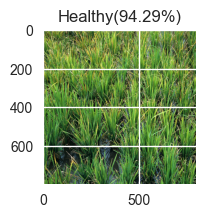

----------------------------------------------------------------------------------
1/1 [==============================] - 0s 131ms/step


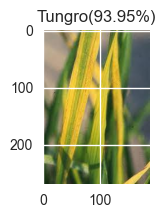

----------------------------------------------------------------------------------


In [56]:
import os
import cv2
import numpy as np
path = "D:/Testing"
for img in os.listdir(path):
    try:
        image = cv2.imread(os.path.join(path, img))
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        img_resized=cv2.resize(image, (img_width, img_height))
        new_image=np.expand_dims(img_resized,axis=0)
        # print(image.shape)

        prediction = new_model.predict(new_image)

        class_output = class_list[np.argmax(prediction)]
        #print(class_output)
        predicted_acuracy = ("{:.2%}".format(np.array(prediction[0])[np.argmax(prediction)]))
        #print(predicted_acuracy)
        
        plt.figure(figsize = (2,2))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)
        plt.title(class_output + "(" + predicted_acuracy + ")")
        plt.show()

    except Exception as e:
        print(e)
    print("----------------------------------------------------------------------------------")

---

### Handling Invalid or Low Quality Image

1/1 [==============================] - 0s 153ms/step
33.14%
Invalid Image!  try to test another image.


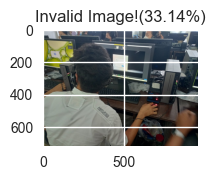

In [64]:
import cv2
import numpy as np

img=cv2.imread("D:/invalid.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_resized=cv2.resize(img, (img_width, img_height))
image=np.expand_dims(img_resized,axis=0)
#print(image.shape)

# prediction = trained_model.model.predict(image)
prediction = new_model.predict(image)
#print(prediction)

class_output = class_list[np.argmax(prediction)]
#print(class_output)

accuracy = np.array(prediction[0])[np.argmax(prediction)]
predicted_acuracy = ("{:.2%}".format(accuracy))
print(predicted_acuracy)

if(accuracy * 100 < 75):
    class_output = "Invalid Image!"
    print(class_output, " try to test another image.")

plt.figure(figsize = (2,2))
plt.imshow(img)
plt.title(class_output + "(" + predicted_acuracy + ")")
plt.show()